In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import json
import pathlib
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img
sns.set()

from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from IPython.display import display 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import skimage.io
from selective_search import selective_search, box_filter


In [3]:
# meta_data_dir = './Output_clean'
# meta_data_labels = sorted(os.listdir(meta_data_dir))
# # print(meta_data_labels[0])


In [4]:
flowers_dir = './Crop_img/'
flower_labels = sorted(os.listdir(flowers_dir))
flower_labels

['Babi',
 'Calimerio',
 'Chrysanthemum',
 'Hydrangeas',
 'Lisianthus',
 'PingPong',
 'Rosy',
 'Tana']

20


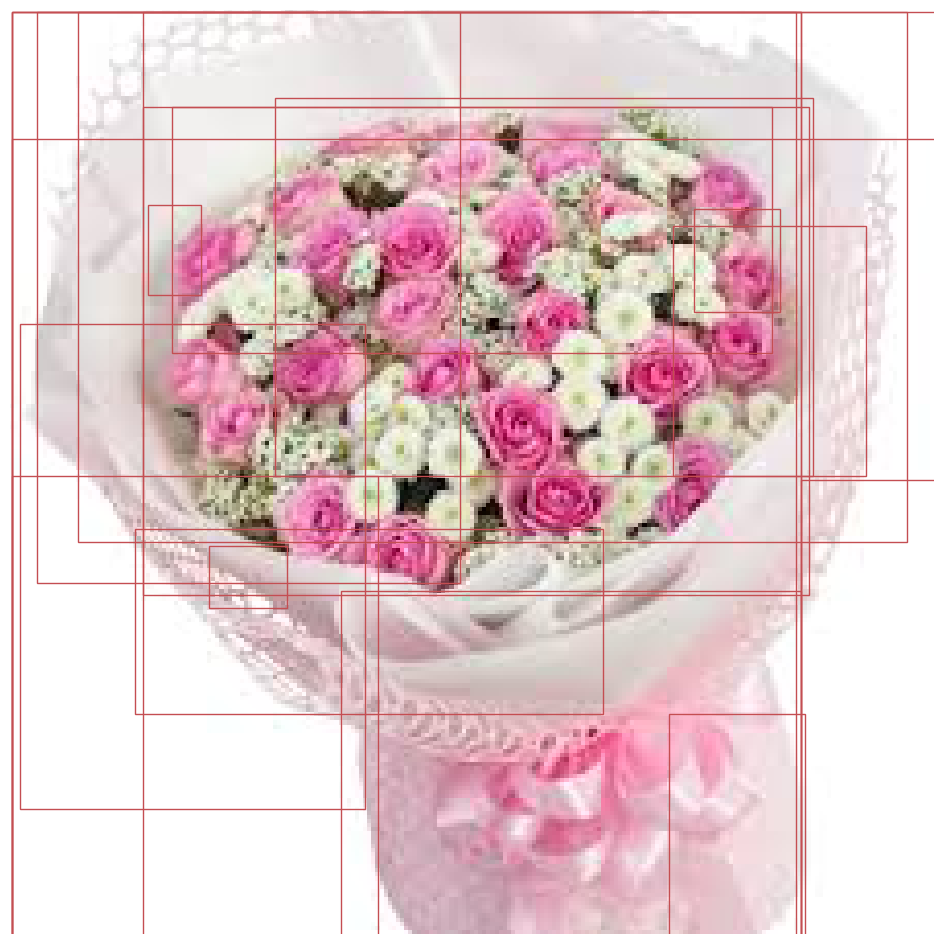

In [5]:
# import skimage.io
# from selective_search import selective_search, box_filter

path_ = "./Flowers/Calimerio/calimero_150.jpg"
image = skimage.io.imread(path_)

boxes = selective_search(image, mode='quality', random_sort=True)
boxes_filter = box_filter(boxes, min_size=1, topN=20)

print(len(boxes_filter))
fix, ax = plt.subplots(figsize=(12,12))
ax.axis('off')
ax.matshow(image)
for i in boxes_filter:
    rect = matplotlib.patches.Rectangle((i[0], i[1]), i[2] - i[0], i[3] - i[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [3]:
def get_crop_cordinate(cord1, cord2):
    x1, y1 = cord1
    x2, y2 = cord2
    x = min(x1, x2)
    y = min(y1, y2)
    return (min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2))


In [4]:
def show_bounding_data_(meta_dir):
    temp_df = pd.DataFrame(data={
        "flower": [],
        "path": [],
        "x1": [],
        "y1": [],
        "x2": [],
        "y2": [],
    })
    images = []
    meta_data_label = sorted(os.listdir(meta_dir))
    counter = 0
    for file in meta_data_label:
        f = open(meta_dir + "/" + file)
        meta_data_ = json.load(f)
        # print(meta_data_)
        try:
            flower_name = meta_data_['imagePath'].split('\\')[-2]
            current_path = '/'.join(meta_data_['imagePath'].split('\\')[-2:])
            file_path = "./Flowers/" + "/".join(meta_data_['imagePath'].split("\\")[-2:])
        except:
            flower_name = meta_data_['imagePath'].split('/')[-2]
            current_path = '/'.join(meta_data_['imagePath'].split('/')[-2:])
            file_path = "./Flowers/" + "/".join(meta_data_['imagePath'].split("/")[-2:])
            
        
        source_img = Image.open(file_path).convert("RGB")
        draw = ImageDraw.Draw(source_img)
        
        for k, i in enumerate(meta_data_['shapes']):
            
            crop_cord = get_crop_cordinate(i['points'][0], i['points'][1])
            cropped = source_img.crop(crop_cord)
            if "/" in meta_data_['imagePath']:
                file_name = meta_data_['imagePath'].split('/')[-1].split(".")[0] + f"_{k}.jpg"
            else:
                file_name = meta_data_['imagePath'].split('\\')[-1].split(".")[0] + f"_{k}.jpg"
            new_row = pd.DataFrame(data=[{"flower": flower_name,
                        "path": file_path,
                        "x1": crop_cord[0],
                        "y1": crop_cord[0],
                        "x2": crop_cord[0],
                        "y2": crop_cord[0]}])
            temp_df = pd.concat([temp_df, new_row], ignore_index=True)
            # try:
            #     cropped.save(f"./Crop_img/{flower_name}/{file_name}")
            #     counter += 1
            # except Exception as e: 
            #     print(e, crop_cord, current_path, source_img.size)
    print("Finised", counter, "images")
    return temp_df
    


In [38]:
def get_coco_cordinate(cord1, cord2):
    x1, y1 = cord1
    x2, y2 = cord2
    x = min(x1, x2)
    y = min(y1, y2)
    return (min(x1, x2), min(y1, y2), abs(x2 - x1), abs(y2 - y1))


In [47]:
def COCO_format(meta_dir):
    result = []
    images = []
    meta_data_label = sorted(os.listdir(meta_dir))
    counter = 0
    for file in meta_data_label:
        f = open(meta_dir + "/" + file)
        meta_data_ = json.load(f)
        each_file = {}
        try:
            flower_name = meta_data_['imagePath'].split('\\')[-2]
            current_path = '/'.join(meta_data_['imagePath'].split('\\')[-2:])
            file_path = "./Flowers/" + "/".join(meta_data_['imagePath'].split("\\")[-2:])

            each_file['path'] = file_path 
            each_file['boxes'] = []
        except:
            flower_name = meta_data_['imagePath'].split('/')[-2]
            current_path = '/'.join(meta_data_['imagePath'].split('/')[-2:])
            file_path = "./Flowers/" + "/".join(meta_data_['imagePath'].split("/")[-2:])

            each_file['path'] = file_path 
            each_file['boxes'] = []
            
        
        source_img = Image.open(file_path).convert("RGB")
        draw = ImageDraw.Draw(source_img)
        
        for k, i in enumerate(meta_data_['shapes']):
            points = i['points']
            each_file['boxes'].append(get_coco_cordinate(points[0], points[1]))
            if abs(points[0][0] - points[1][0]) < 1 or abs(points[0][1] - points[1][1]) < 1:
                print(meta_data_['imagePath'], points[0][0] - points[1][0], points[0][1] - points[1][1])
                continue
        result.append(each_file)
            # print(flower_name, file_path, points)
    print("Finised", counter, "images")
    return result


In [50]:
json_coco = {}
for i in flower_labels:
    json_coco[i] = []
    print("-" * 20, i, "-" * 20)
    json_coco[i] = COCO_format(f"./Meta/{i}")

-------------------- Babi --------------------
..\..\Flowers\Babi\babi_512.jpg 0.0 -3.5502958579881607
Finised 0 images
-------------------- Calimerio --------------------
Finised 0 images
-------------------- Chrysanthemum --------------------
Finised 0 images
-------------------- Hydrangeas --------------------
..\Flowers\Hydrangeas\hydrangeas_109.jpg 8.0 0.0
..\Flowers\Hydrangeas\hydrangeas_112.jpg 0.0 -12.0
Finised 0 images
-------------------- Lisianthus --------------------
Finised 0 images
-------------------- PingPong --------------------
Finised 0 images
-------------------- Rosy --------------------
Finised 0 images
-------------------- Tana --------------------
Finised 0 images


In [56]:
with open("./COCO_Metadata.json", "w") as file :
    json.dump(json_coco, file, indent=4)

In [32]:

def show_bounding_data():
    images = []
    for file in meta_data_labels:
        f = open(meta_data_dir + "/" + file)
        meta_data_ = json.load(f)
        
        current_path = '/'.join(meta_data_['imagePath'].split('\\')[-2:])
       
        file_path = flowers_dir + "/".join(meta_data_['imagePath'].split("\\")[-2:])
        source_img = Image.open(file_path).convert("RGB")
        draw = ImageDraw.Draw(source_img)
    
        for k, i in enumerate(meta_data_['shapes']):
            crop_cord = get_crop_cordinate(i['points'][0], i['points'][1])
            file_name = meta_data_['imagePath'].split('\\')[-1].split(".")[0] + f"_{k}.jpg"
            # print(crop_cord, current_path, source_img.size)
            cropped = source_img.crop(crop_cord)
            try:
                cropped.save(f"./Crop_img/{file_name}")
            except:
                print("failed", crop_cord, current_path, source_img.size)

In [28]:
show_bounding_data()

failed (134.0, 44.0, 142.0, 44.0) Hydrangeas/hydrangeas_109.jpg (194, 259)
failed (52.0, 122.0, 52.0, 134.0) Hydrangeas/hydrangeas_112.jpg (239, 211)


Crop_img\Babi\babi_100_0.jpg
Crop_img\Hydrangeas\hydrangeas_101_0.jpg
Crop_img\Rosy\rosy_100_0.jpg


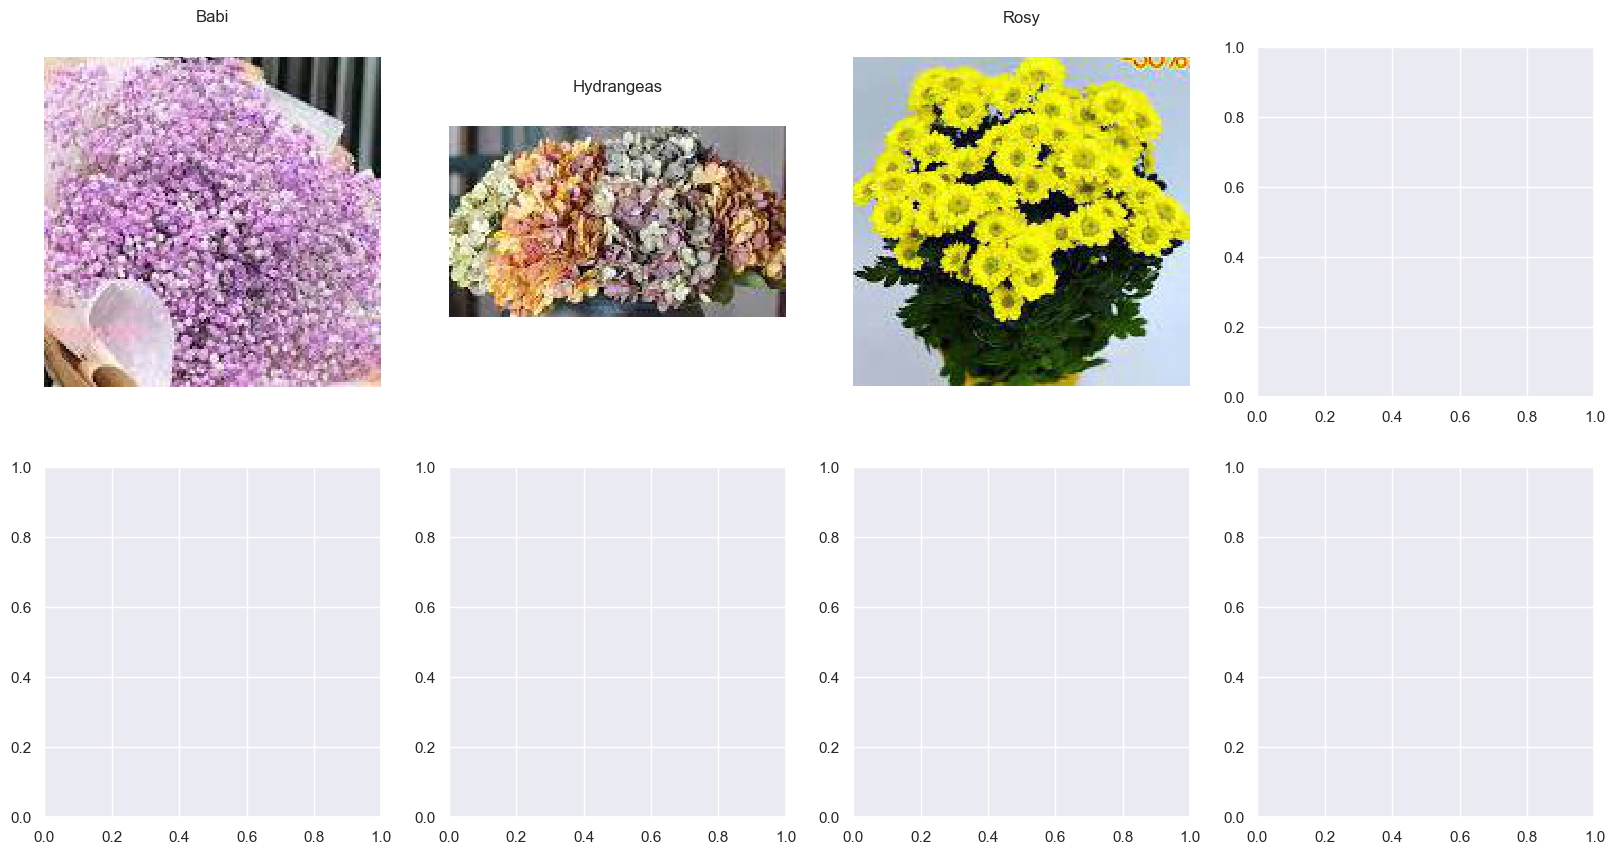

In [96]:
import random


X = []
y = []

majority = ['Babi',
 'Calimerio',
 'Chrysanthemum',
 'Lisianthus',
 'Pingpong','Rosy']

minority = ['Tana', 'Hydrangeas']

test = ['Babi',
 'Chrysanthemum',
 'Lisianthus',
 'Pingpong','Rosy']

chosen_flower = flower_labels.copy()


img_size = 256

fig,ax = plt.subplots(2, 4, figsize=(20,10))
ax=ax.flatten()

flowers_dir_path_object = pathlib.Path(flowers_dir)

for label_number,flower in enumerate(chosen_flower):
    # get all paths of images inside flower subdirectory
    flower_images_paths = list(flowers_dir_path_object.glob(f'{flower}/*.jpg'))
    ax[label_number].set_title(flower.capitalize())
    ax[label_number].axis('off')
    print(flower_images_paths[0].__str__())
    flower_img = np.array(load_img(flower_images_paths[0].__str__()))
    ax[label_number].matshow(flower_img)
    # print(flower_images_paths[0].__str__())
    for image in flower_images_paths:
        # load and resize image
        resized_image = load_img(str(image),target_size=(img_size, img_size))

        # append features in X and labels in y
        y.append(label_number)
        X.append(np.array(resized_image))
        
        

In [53]:
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

# X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X, np.array(y_binary),random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print("-" * 50)
# print('X train shape: {}'.format(X_train_binary.shape))
# print('X test shape: {}'.format(X_test_binary.shape))

X train shape: (3465, 256, 256, 3)
X test shape: (1156, 256, 256, 3)
--------------------------------------------------


In [59]:
base_model = tf.keras.applications.InceptionResNetV2(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)  

219055592/219055592 [==============================] - 134s 1us/step


In [60]:
base_model.trainable = False

m = keras.Sequential([
    # tf.keras.layers.Resizing(150, 150),
     keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    base_model,
    keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(8)
    
])
m.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

m.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 55296)             0         
                                                                 
 dense_17 (Dense)            (None, 64)                3539008   
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 8)                 264       
                                                      

In [61]:
history = m.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
87/87 [==============================] - 34s 295ms/step - loss: 8.0657 - accuracy: 0.0898 - val_loss: 8.5266 - val_accuracy: 0.0722
Epoch 2/5
87/87 [==============================] - 23s 263ms/step - loss: 8.1372 - accuracy: 0.0942 - val_loss: 8.5266 - val_accuracy: 0.0722
Epoch 3/5
87/87 [==============================] - 23s 269ms/step - loss: 8.1372 - accuracy: 0.0942 - val_loss: 8.5266 - val_accuracy: 0.0722
Epoch 4/5
87/87 [==============================] - 24s 279ms/step - loss: 8.1372 - accuracy: 0.0942 - val_loss: 8.5266 - val_accuracy: 0.0722
Epoch 5/5
87/87 [==============================] - 24s 278ms/step - loss: 8.1372 - accuracy: 0.0942 - val_loss: 8.5266 - val_accuracy: 0.0722


In [62]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.axhline(y = max(train_metric), color = 'r', linestyle = '-')
    plt.axhline(y = max(val_metric), color = 'b', linestyle = '-')

    plt.show()

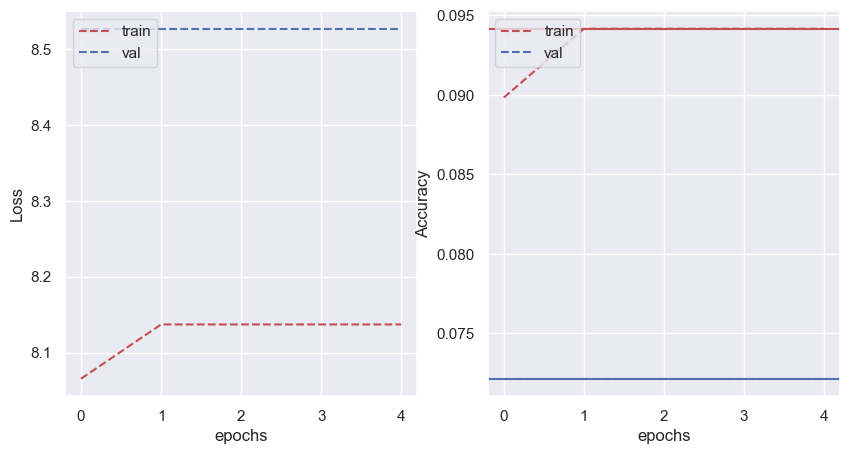

In [63]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

37/37 [==============================] - 11s 221ms/step


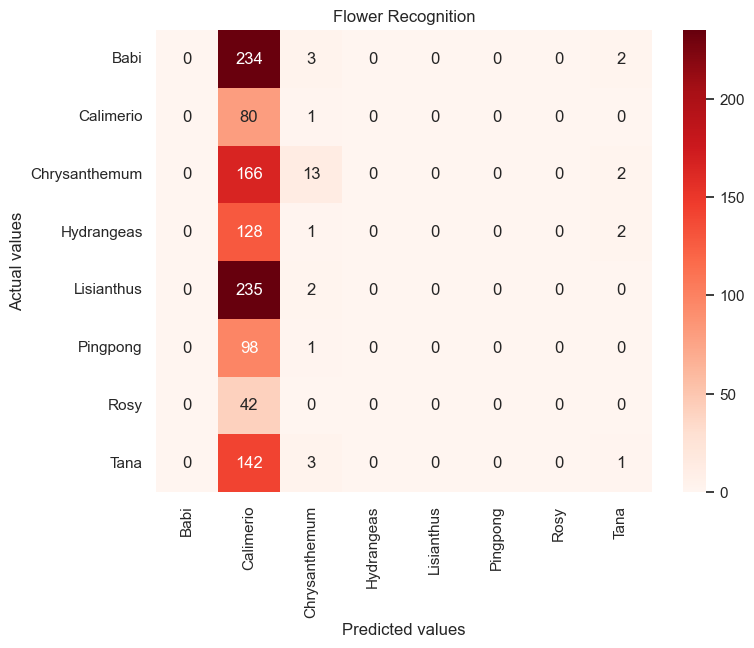

In [64]:
predictions = m.predict(X_test)
max_predictions = [np.argmax(value) for value in predictions]
max_predictions[:5]
confusion_matrix_result = confusion_matrix(y_test,max_predictions)

labels = flower_labels
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result,annot=True,cmap='Reds',fmt='.0f',xticklabels=labels,yticklabels=labels)
plt.title('Flower Recognition')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()